# Specify and set the filepath structure for the project data to work with

## 1. Import libraries

In [1]:
# Import necessary libraries
import os
import requests
import gzip
import shutil
import unicodedata
import pandas as pd
from pandas import json_normalize
import json

# Optional: to suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


## 2. Introductionary examples for os library

In [ ]:
# Illustrate how os.getcwd(), os.path.join(), os.path.exists() work

path = os.path.join(os.getcwd(),"..", 'data')
print(f"The path {path} exists:\n{os.path.exists(path)}\n") # returns True if the folder or file exists

path = os.path.join(path, '_original', 'All_Beauty.jsonl.gz')
print(f"The path {path} exists:\n{os.path.exists(path)}")

In [ ]:
# Illustrate how os.path.pardir and os.path.abspath() work

# get the relative path of the parent folder of the working directory
path = os.path.join(os.getcwd(), os.pardir)
print(path)

# and return the absolute path of the parent directory
path = os.path.abspath(path)
print(path)

## 3. Create project folder structure and download data

In [14]:
# Get the current notebook working directory ("./notebooks")  for the "./../data" folder and it's subolders to be created:
path = os.path.join(os.getcwd(), os.pardir) # get the relative path of the parent folder of the working directory
path = os.path.abspath(path) # and return the absolute path of the parent directory for the data folder
path = os.path.join(path, 'data') # path variable for "data" folder within the local github project on your machine

# Check if the structure within data folder is existing:
if os.path.exists(os.path.join(path, '_original')) == False:
    # create the folder
    os.mkdir(os.path.join(path, '_original'))
    # download the data from the web
    url_user = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/All_Beauty.jsonl.gz'
    url_meta = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/meta_categories/meta_All_Beauty.jsonl.gz'
    
    response_user = requests.get(url_user)
    response_meta = requests.get(url_meta)

    if response_user.status_code == 200:
        with open(os.path.join(path, '_original','All_Beauty.jsonl.gz'), 'wb') as file:
            file.write(response_user.content)
        print(f" File 'All_Beaty.json.gz' dowloaded sucessfully")
    else:
        print(f" Failed to download 'All_Beaty.json.gz'. \nPlease download manually to './data/_original' folder.")

    if response_meta.status_code == 200:
        with open(os.path.join(path, '_original', 'meta_All_Beauty.jsonl.gz'), 'wb') as file:
            file.write(response_meta.content)
        print(f" File 'meta_All_Beaty.json.gz' dowloaded sucessfully")
    else:
        print(f" Failed to download 'meta_All_Beaty.json.gz'. \nPlease download manually to './data/_original' folder.")

elif os.path.exists(os.path.join(path, 'json_files')) == False:    
    source = os.path.join(path, '_original')
    destination = os.path.join(path, 'json_files')
    
    # create the folder
    os.mkdir(destination)
    
    # check if unzip and shutil packages are installed:
    pip_list = os.popen('pip list').read().strip() #pip list all installed packages and remove spaces
    #print(f"pip list: {pip_list}")
    Package = list(pip_list.split("\n")) #split by end of line
    #print(f"Package: {Package}")

    c = 0
    for i in Package:
        if "gzip" in i or "shutil" in i:
            c = c + 1

    if c == 2:
        # unzip downloaded json files from _original into json_files
        for filename in os.listdir(source):
            if filename.endswith('.gz'): 
                with gzip.open(filename, 'rb') as f_in:
                    with open(filename[:-3], 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                        shutil.move(os.path.join(source, f_out), destination)
    else:
        print("Please extract the .gz files in './data/_original' and \nmove them to './data/json_files' for this notebook to work properly!")


elif os.path.exists(os.path.join(path, 'csv_transformed')) == False:
    os.mkdir(os.path.join(path, 'csv_transformed'))

elif os.path.exists(os.path.join(path, 'data_clean')) == False:
    os.mkdir(os.path.join(path, 'data_clean'))

elif os.path.exists(os.path.join(path, 'json_normalized')) == False:
    os.mkdir(os.path.join(path, 'json_normalized'))

elif os.path.exists(os.path.join(path, 'embeddings_output')) == False:
    os.mkdir(os.path.join(path, 'embeddings_output'))

elif os.path.exists(os.path.join(path, 'embeddings_dim_reduction')) == False:
    os.mkdir(os.path.join(path, 'embeddings_dim_reduction'))

elif os.path.exists(os.path.join(path, 'embeddings_dim_reduction')) == False:
    os.mkdir(os.path.join(path, 'embeddings_dim_reduction'))

elif os.path.exists(os.path.join(path, 'embeddings_dim_reduction')) == False:
    os.mkdir(os.path.join(path, 'embeddings_dim_reduction'))

elif os.path.exists(os.path.join(path, 'text_analysis')) == False:
    os.mkdir(os.path.join(path, 'text_analysis'))
    os.mkdir(os.path.join(path, 'text_analysis', 'user_vectors'))
    os.mkdir(os.path.join(path, 'text_analysis', 'product_vectors'))
   
elif os.path.exists(os.path.join(path, 'embeddings_output')) == False:
    os.mkdir(os.path.join(path, 'embeddings_output'))

elif os.path.exists(os.path.join(path, 'embeddings_dim_reduction')) == False:
    os.mkdir(os.path.join(path, 'embeddings_dim_reduction'))

## 4. Create a flattend CSV from the downloaded JSON files

Convert the nested JSON datasets of the items descpritions and users ratings into flattend CSV files

In [15]:
# get the relative path of the parent folder of the working directory
# and return the absolute path of the parent directory for the data folder
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
path = os.path.join(path, 'data') # path variable for "data" folder within the local github project on your machine

if os.path.exists(os.path.join(path, 'json_normalized', 'normalized_user.csv')) == False:
    # Flatten nested json file of 'user' data
    json_file_user = '.\..\data\json_files\All_Beauty.jsonl'
    nested_data = []
    with open(json_file_user, 'r') as file:
        for line in file:
            nested_data.append(json.loads(line))

    df_user = json_normalize(nested_data)
    df_user.to_csv(r'.\..\data\json_normalized\normalized_user.csv', index=False)
    
    print("Nested JSON file has been flattened and saved as \n'.\data\json_normalized\normalized_user.csv'.")

# 
elif os.path.exists(os.path.join(path, 'csv_transformed', 'meta.csv')) == False:
    json_file_meta = '.\..\data\json_files\meta_All_Beauty.jsonl'
    df_meta = pd.read_json(json_file_meta, lines=True)
    # Specify the path for the CSV:
    csv_meta = r'.\..\data\csv_transformed\meta.csv'
    # Save the DataFrame as a CSV file
    df_meta.to_csv(csv_meta, index=False)
    
    print(f"JSON file has been converted to CSV and saved as '{csv_meta}'.")

else:
    print("Most likely the corresponding folder structure and csv file already exists.\nIn case it does not please repeat the previous steps or adapt the folder structure manually")

Most likely the corresponding folder structure and csv file already exists.
In case it does not please repeat the previous steps or adapt the folder structure manually


Convert the JSON dataset of 'meta' into a CSV file

In [53]:
if os.path.exists('.\..\data\csv_transformed\meta.csv') == False:
    json_file_meta = '.\..\data\json_files\meta_All_Beauty.jsonl'
    df_meta = pd.read_json(json_file_meta, lines=True)
    # Specify the path for the CSV:
    csv_meta = r'.\..\data\csv_transformed\meta.csv'
    # Save the DataFrame as a CSV file
    df_meta.to_csv(csv_meta, index=False)
    
    print(f"JSON file has been converted to CSV and saved as '{csv_meta}'.")

## Metadata analysis

2. Load Dataset

In [54]:
csv_meta = r'.\..\data\csv_transformed\meta.csv'
df_meta= pd.read_csv(csv_meta)

In [55]:
df_meta.head(5)


,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Howard Products,[],{'Package Dimensions': '7.1 x 5.5 x 3 inches; ...,B01CUPMQZE,NaN
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Yes To,[],"{'Item Form': 'Powder', 'Skin Type': 'Acne Pro...",B076WQZGPM,NaN
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Levine Health Products,[],{'Manufacturer': 'Levine Health Products'},B000B658RI,NaN
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Cherioll,[],"{'Brand': 'Cherioll', 'Item Form': 'Powder', '...",B088FKY3VD,NaN
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7,"['Material: 304 Stainless Steel; Brass tip', '...",['The Precision Plunger Bars are designed to w...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Precision,[],{'UPC': '644287689178'},B07NGFDN6G,NaN


In [56]:
df_meta['images'][0]

"[{'thumb': 'https://m.media-amazon.com/images/I/41qfjSfqNyL._SS40_.jpg', 'large': 'https://m.media-amazon.com/images/I/41qfjSfqNyL.jpg', 'variant': 'MAIN', 'hi_res': None}, {'thumb': 'https://m.media-amazon.com/images/I/41w2yznfuZL._SS40_.jpg', 'large': 'https://m.media-amazon.com/images/I/41w2yznfuZL.jpg', 'variant': 'PT01', 'hi_res': 'https://m.media-amazon.com/images/I/71i77AuI9xL._SL1500_.jpg'}]"

## Extract one large image from the 'images' column:

In [57]:
def extract_first_large_image(images):
    if isinstance(images, (list, tuple)) and len(images) > 0:
        return images[0].get('large', None)  # Get the 'large' URL from the first image
    return None  # Return None if no images are available

df_meta['large_image'] = df_meta['images'].apply(extract_first_large_image)

In [58]:
df_meta['large_image'][0]

In [59]:
df_meta['details'][4]

"{'UPC': '644287689178'}"

In [60]:
df_meta.shape

(112590, 15)

In [61]:
df_meta.dtypes

main_category       object
title               object
average_rating     float64
rating_number        int64
features            object
description         object
price              float64
images              object
videos              object
store               object
categories          object
details             object
parent_asin         object
bought_together    float64
large_image         object
dtype: object

Identify columns containing lists: (we can't process those)

In [62]:
for col in df_meta.columns:
    if df_meta[col].apply(lambda x: isinstance(x, list)).any():
        print(f"Column '{col}' contains lists.")

Convert lists to hashable tuples:

In [63]:
for col in df_meta.columns:
    if df_meta[col].apply(lambda x: isinstance(x, list)).any():
        df_meta[col] = df_meta[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)

Identify columns with dict:

In [64]:
for col in df_meta.columns:
    if df_meta[col].apply(lambda x: isinstance(x, dict)).any():
        print(f"Column '{col}' contains dictionaries.")

In [65]:
col_with_lists = ['features', 'description', 'images', 'videos', 'categories', 'details']
duplicates = df_meta.duplicated(subset=[col for col in df_meta.columns if col not in col_with_lists])
duplicates.sum()

np.int64(0)

In [66]:
df_meta.dtypes

main_category       object
title               object
average_rating     float64
rating_number        int64
features            object
description         object
price              float64
images              object
videos              object
store               object
categories          object
details             object
parent_asin         object
bought_together    float64
large_image         object
dtype: object

In [67]:
# Get a concise summary of the DataFrame
df_meta.info()
# Display basic statistics of numeric columns
df_meta.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112590 entries, 0 to 112589
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   main_category    112590 non-null  object 
 1   title            112578 non-null  object 
 2   average_rating   112590 non-null  float64
 3   rating_number    112590 non-null  int64  
 4   features         112590 non-null  object 
 5   description      112590 non-null  object 
 6   price            17704 non-null   float64
 7   images           112590 non-null  object 
 8   videos           112590 non-null  object 
 9   store            101246 non-null  object 
 10  categories       112590 non-null  object 
 11  details          112590 non-null  object 
 12  parent_asin      112590 non-null  object 
 13  bought_together  0 non-null       float64
 14  large_image      0 non-null       object 
dtypes: float64(3), int64(1), object(11)
memory usage: 12.9+ MB


,average_rating,rating_number,price,bought_together
count,112590.000000,112590.000000,17704.00000,0.0
mean,3.883488,50.541345,27.25573,NaN
std,0.874384,310.992502,50.47202,NaN
min,1.000000,1.000000,0.01000,NaN
25%,3.400000,3.000000,9.99000,NaN
50%,4.000000,9.000000,16.99000,NaN
75%,4.500000,28.000000,29.90000,NaN
max,5.000000,30206.000000,2548.98000,NaN


### !! many nulls in column 'price'

In [68]:
# Check for missing values
missing_values = df_meta.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 main_category           0
title                  12
average_rating          0
rating_number           0
features                0
description             0
price               94886
images                  0
videos                  0
store               11344
categories              0
details                 0
parent_asin             0
bought_together    112590
large_image        112590
dtype: int64


## User data analysis

2. Load Dataset

In [69]:
# Load the dataset into a Pandas DataFrame
file_path = r'.\..\data\json_normalized\normalized_user.csv'  # Update this with your file path
df_user = pd.read_csv(file_path)

# Display the first few rows of the dataset
df_user.head()


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


3. Data Exploration

In [70]:
# Get a concise summary of the DataFrame
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             701528 non-null  float64
 1   title              701368 non-null  object 
 2   text               701316 non-null  object 
 3   images             701528 non-null  object 
 4   asin               701528 non-null  object 
 5   parent_asin        701528 non-null  object 
 6   user_id            701528 non-null  object 
 7   timestamp          701528 non-null  int64  
 8   helpful_vote       701528 non-null  int64  
 9   verified_purchase  701528 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 48.8+ MB


In [71]:
# Display basic statistics of numeric columns
df_user.describe()

,rating,timestamp,helpful_vote
count,701528.000000,7.015280e+05,701528.000000
mean,3.960245,1.554781e+12,0.923588
std,1.494452,8.005792e+10,5.471391
min,1.000000,9.730527e+11,0.000000
25%,3.000000,1.501616e+12,0.000000
50%,5.000000,1.571595e+12,0.000000
75%,5.000000,1.614647e+12,1.000000
max,5.000000,1.694220e+12,646.000000


In [72]:
# Check for missing values
missing_values = df_user.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 rating                 0
title                160
text                 212
images                 0
asin                   0
parent_asin            0
user_id                0
timestamp              0
helpful_vote           0
verified_purchase      0
dtype: int64


In [73]:
# Check for duplicate rows
duplicates = df_user.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 7275


In [74]:
# Replace 'column_name' with the actual column name
# unique_values = df['column_name'].unique()
# print(f"Unique values in 'column_name':\n{unique_values}")
unique_values = df_user.nunique()
unique_values

rating                    5
title                376390
text                 643624
images                58938
asin                 115709
parent_asin          112565
user_id              631986
timestamp            694027
helpful_vote            240
verified_purchase         2
dtype: int64

In [75]:
# Rename columns:
new_cols_names={'rating':'rating', 'title':'review_title', "text":"text_review", "images":"user_images",
                "asin":"product_ID", "parent_asin":"parent_ID", "user_id":"user_ID", "timestamp":"timestamp",
                "helpful_vote":"helpful_review_vote", "verified_purchase":"user_purchase_verification"
                }

df_user.rename(new_cols_names, axis=1, inplace=True)

In [76]:
# Display the number of unique values for each column
for col in df_user.columns:
    print(f"Column: {col}")
    print(f"Number of unique values: {df_user[col].nunique()}")
    print(f"Unique values:\n{df_user[col].unique()[:10]}")  # Display first 10 unique values for brevity
    print("-" * 50)


Column: rating
Number of unique values: 5
Unique values:
[5. 4. 1. 3. 2.]
--------------------------------------------------
Column: review_title
Number of unique values: 376390
Unique values:
['Such a lovely scent but not overpowering.'
 'Works great but smells a little weird.' 'Yes!' 'Synthetic feeling' 'A+'
 'Pretty Color' 'Handy' 'Meh' 'Great for at home use and so easy to use!'
 'Nice shampoo for the money']
--------------------------------------------------
Column: text_review
Number of unique values: 643624
Unique values:
["This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!"
 'This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputting. (gra

In [77]:
df_user.shape

(701528, 10)

In [78]:
# Check unique combinations across two or more columns
# unique_combinations = df[['column1', 'column2']].drop_duplicates()
# print(f"Unique combinations of 'column1' and 'column2':\n{unique_combinations}")


In [79]:
# Replace 'column_name' with your categorical column
most_frequent = df_user['rating'].value_counts().idxmax()
least_frequent = df_user['rating'].value_counts().idxmin()

print(f"Most frequent value in 'rating': {most_frequent}")
print(f"Least frequent value in 'rating': {least_frequent}")


Most frequent value in 'rating': 5.0
Least frequent value in 'rating': 2.0


EXAMPLE (extra) fpr product and review data

Unique Product IDs & Unique Reviews

In [80]:
print(f"Number of unique products: {df_user['product_ID'].nunique()}")
# print(f"Unique Product IDs:\n{df_user['product_ID'].unique()[:10]}")  # Show top 10
print(f"Number of unique reviewers: {df_user['user_ID'].nunique()}")

Number of unique products: 115709
Number of unique reviewers: 631986


for Unique Ratings

In [81]:
print(f"Unique ratings: {df_user['rating'].unique()}")
print(f"Rating counts:\n{df_user['rating'].value_counts()}")


Unique ratings: [5. 4. 1. 3. 2.]
Rating counts:
rating
5.0    420726
1.0    102080
4.0     79381
3.0     56307
2.0     43034
Name: count, dtype: int64


Analyze the product

In [82]:
unique_items_per_user = df_user.groupby('user_ID')['product_ID'].count().sort_values(ascending=False)
#unique_items_per_user.nunique()
unique_items_per_user.head(10)

user_ID
AG73BVBKUOH22USSFJA5ZWL7AKXA      165
AEZP6Z2C5AVQDZAJECQYZWQRNG3Q      146
AEMP3A7IKW37CMWFXNKXWW6HGJHA_1    115
AHDVSLWHSORYGG3S5QZMVDFNOXUQ      108
AGZUJTI7A3JFKB4FP5JOH6NVAJIQ_1     87
AFDYIK3FNPY2JFBQYUWC6GSBMIRQ_2     83
AFXF3EGQTQDXMRLDWFU7UBFQZB7Q       81
AEJU3Z6HDAERETMYI2CXBQVPPDFA       79
AHY2TURQPNIDXZGH2CMQLZ343YMQ       69
AEOK4TQIKGO23SJKZ6PW4FETNNDA_1     68
Name: product_ID, dtype: int64

Analyze the rating

In [83]:
no_of_rated_products_per_user = df_user.groupby('user_ID')['rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head(10)

user_ID
AG73BVBKUOH22USSFJA5ZWL7AKXA      165
AEZP6Z2C5AVQDZAJECQYZWQRNG3Q      146
AEMP3A7IKW37CMWFXNKXWW6HGJHA_1    115
AHDVSLWHSORYGG3S5QZMVDFNOXUQ      108
AGZUJTI7A3JFKB4FP5JOH6NVAJIQ_1     87
AFDYIK3FNPY2JFBQYUWC6GSBMIRQ_2     83
AFXF3EGQTQDXMRLDWFU7UBFQZB7Q       81
AEJU3Z6HDAERETMYI2CXBQVPPDFA       79
AHY2TURQPNIDXZGH2CMQLZ343YMQ       69
AEOK4TQIKGO23SJKZ6PW4FETNNDA_1     68
Name: rating, dtype: int64

The most popular products

In [84]:
top_products = df_user.groupby('product_ID')['rating'].count().sort_values(ascending=False)

top_products.head(10)

product_ID
B007IAE5WY    1962
B00EEN2HCS    1750
B07C533XCW    1513
B00R1TAN7I    1372
B08L5KN7X4    1343
B019GBG0IE    1328
B0719KWG8H    1168
B0092MCQZ4    1128
B0107QYW14    1112
B0070Z7KME     934
Name: rating, dtype: int64

<Axes: xlabel='product_ID'>

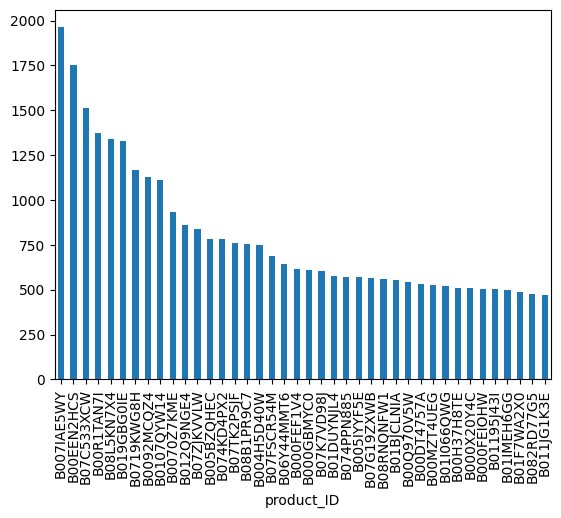

In [85]:
top_products.head(40).plot(kind = "bar")

In [86]:
# example of 1 user analysis
df_user_2 = df_user[df_user['user_ID'] == 'AG73BVBKUOH22USSFJA5ZWL7AKXA']
df_user_2.head(2)

,rating,review_title,text_review,user_images,product_ID,parent_ID,user_ID,timestamp,helpful_review_vote,user_purchase_verification
1738,5.0,scrunchies get used in my house all the time,"when my daughter and granddaughter come over, ...",[],B09L563Q84,B09L563Q84,AG73BVBKUOH22USSFJA5ZWL7AKXA,1641262633460,0,False
1739,5.0,smells good,I just put this on and it was creamy and a sma...,[],B09KT4RJG6,B09KT4RJG6,AG73BVBKUOH22USSFJA5ZWL7AKXA,1640218597848,0,False


4. Data Cleaning

In [87]:
df_user.head(2)

,rating,review_title,text_review,user_images,product_ID,parent_ID,user_ID,timestamp,helpful_review_vote,user_purchase_verification
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True


In [88]:
df_user["timestamp"] = pd.to_datetime(df_user["timestamp"], unit='ms')
df_user['rating'] = df_user['rating'].astype('int')
df_user['user_purchase_verification'] = df_user['user_purchase_verification'].map({True: 1, False: 0})

In [89]:
df_user.head(2)

,rating,review_title,text_review,user_images,product_ID,parent_ID,user_ID,timestamp,helpful_review_vote,user_purchase_verification
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,1
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,1


In [90]:
df_user['year'] = df_user['timestamp'].dt.year

In [91]:
# Drop duplicate rows, if necessary
df_user.drop_duplicates(inplace=True)

# Handle missing values (example: dropping rows with missing values)
df_user.dropna(inplace=True)  # Or you can fill missing values with `df.fillna(value)`


In [92]:
# Check for duplicate rows
duplicates = df_user.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [93]:
df_user.shape

(693941, 11)

In [94]:
df_user.head(2)

,rating,review_title,text_review,user_images,product_ID,parent_ID,user_ID,timestamp,helpful_review_vote,user_purchase_verification,year
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,1,2020
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,1,2020


Text cleaning

In [95]:
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text) # Remove HTML tags
    text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '[USER]', text) # Remove mentions (e.g., @username)
    text = unicodedata.normalize("NFKC", text) # Normalize unicode characters
    text = re.sub(r'[^a-zA-Z0-9\s.,!?;:]', '', text)  # Remove non-alphanumeric characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text 

In [96]:
df_user['cleaned_text'] = df_user['text_review'].apply(clean_text)

In [97]:
df_user.head(6)

,rating,review_title,text_review,user_images,product_ID,parent_ID,user_ID,timestamp,helpful_review_vote,user_purchase_verification,year,cleaned_text
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,1,2020,this spray is really nice. it smells really go...
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,1,2020,"this product does what i need it to do, i just..."
2,5,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2,1,2020,"smells good, feels great!"
3,1,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,0,1,2022,felt synthetic
4,5,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,0,1,2020,love it
5,4,Pretty Color,The polish was quiet thick and did not apply s...,[{'small_image_url': 'https://images-na.ssl-im...,B00R8DXL44,B00R8DXL44,AGMJ3EMDVL6OWBJF7CA5RGJLXN5A,2020-08-27 22:30:08.138,0,1,2020,the polish was quiet thick and did not apply s...


In [98]:
# Remove generated nulls from 'cleaned_text' column
df_user.dropna(inplace=True)

Save cleaned data

In [99]:
#csv_user_clean = r'.\..\data\data_clean\user_clean_data_ecommerce.csv'
## Save the DataFrame as a CSV file
#df_user.to_csv(csv_user_clean, index=False)

5. Check the Distribution of the Data

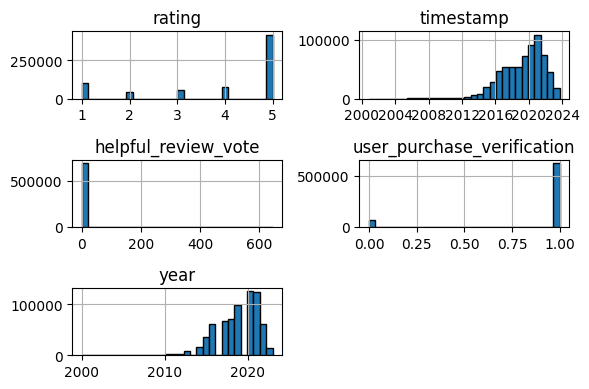

In [100]:
# Display the distribution of numeric columns
df_user.hist(figsize=(6, 4), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

# Count values in categorical columns (replace 'category_column' with actual column name)
# if 'category_column' in df.columns:
#     print(df['category_column'].value_counts())


6. Univariate Analysis

In [101]:
yearly_distribution = df_user['year'].value_counts().sort_index()
yearly_distribution

year
2000         1
2001        11
2002        24
2003        56
2004       130
2005       265
2006       416
2007      1150
2008      1251
2009      1198
2010      1568
2011      1855
2012      2774
2013      7880
2014     16107
2015     35844
2016     62042
2017     67354
2018     71960
2019     98100
2020    125371
2021    123466
2022     60909
2023     14209
Name: count, dtype: int64

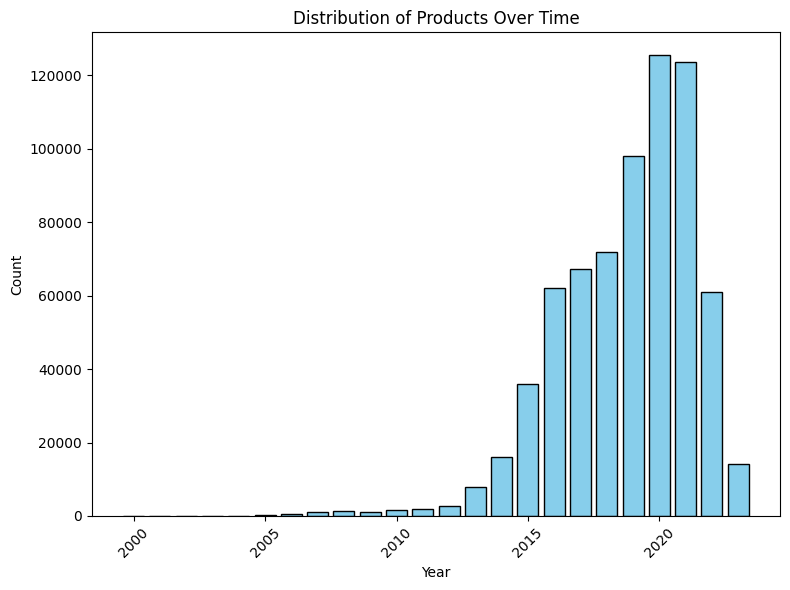

In [102]:
# Plotting the data
plt.figure(figsize=(8,6))
plt.bar(yearly_distribution.index, yearly_distribution.values, color='skyblue', edgecolor='black')  # Bar plot

plt.title('Distribution of Products Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [103]:
df_user = df_user[~df_user['rating'].isnull()]
df_user['rating'].unique()

array([5, 4, 1, 3, 2])

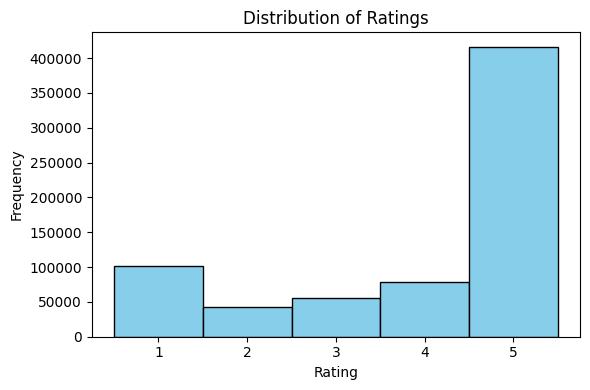

In [104]:
# Plotting the histogram using Matplotlib directly
plt.figure(figsize=(6, 4))
bin_edges = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
plt.hist(df_user['rating'],bins=bin_edges , edgecolor='black', color='skyblue')

# Adding labels and title
plt.xticks(ticks=[1, 2, 3, 4, 5])
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.tight_layout()
plt.show()

### Popularity Based Recommendation

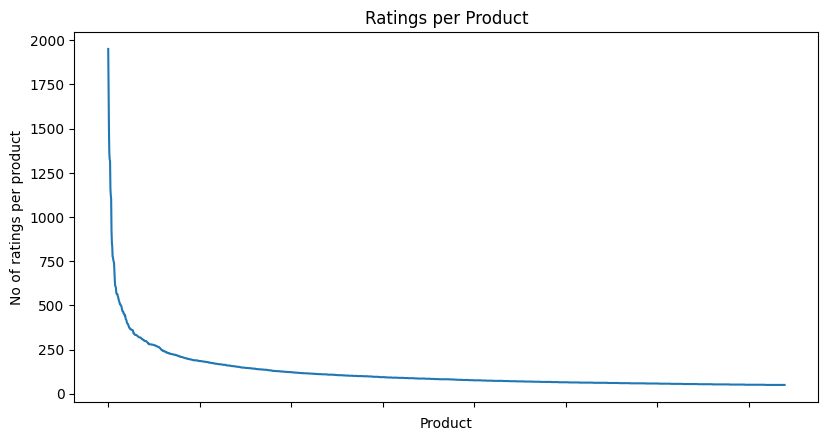

In [105]:
top_items=df_user.groupby("product_ID").filter(lambda x:x['rating'].count() >=50)
top_items.shape
top_items.head(2)

no_of_ratings_per_product = top_items.groupby('product_ID')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('Ratings per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([]) # Remove x labels from the axis (those are IDs)
# ax.set_yscale('log') optionally
plt.show()

Items with the highest rates

In [106]:
top_items.groupby('product_ID')['rating'].mean().sort_values(ascending=False).head()

product_ID
B093GRLKB9    4.950820
B00H3WGN9K    4.948276
B002T5NMGS    4.942308
B07DT5FHY4    4.928571
B07M6MXTH2    4.925532
Name: rating, dtype: float64

Items with the highest number of rates

In [107]:
top_items.groupby('product_ID')['rating'].count().sort_values(ascending=False).head()

product_ID
B007IAE5WY    1951
B00EEN2HCS    1725
B07C533XCW    1497
B00R1TAN7I    1362
B08L5KN7X4    1326
Name: rating, dtype: int64

In [108]:
ratings_mean_count = pd.DataFrame(top_items.groupby('product_ID')['rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(top_items.groupby('product_ID')['rating'].count())
ratings_mean_count.sort_values('rating_counts', ascending=False)

,rating,rating_counts
product_ID,,
B007IAE5WY,4.620707,1951
B00EEN2HCS,4.136812,1725
B07C533XCW,4.464262,1497
B00R1TAN7I,4.029369,1362
B08L5KN7X4,4.010558,1326
...,...,...
B07NY3TFNC,4.160000,50
B08R8YGQX1,3.840000,50
B07R993WM6,4.580000,50


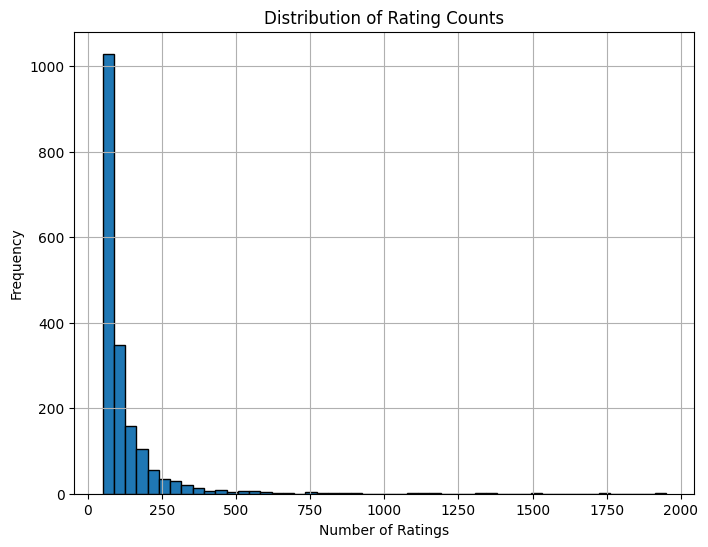

In [109]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True # Ensure that edges of the patches (bars) are visible
ratings_mean_count['rating_counts'].hist(bins=50)
plt.title('Distribution of Rating Counts')
plt.xlabel('Number of Ratings') 
plt.ylabel('Frequency')     
plt.show()

Most of the top products have number of ratings 50

Text(0, 0.5, 'Frequency')

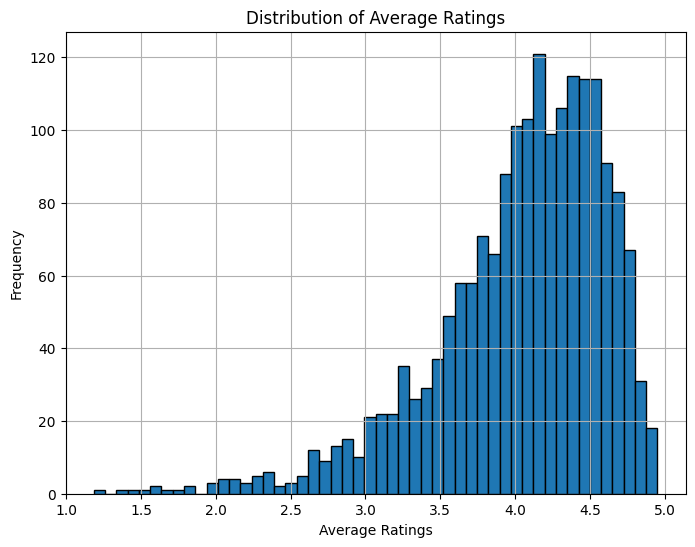

In [110]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Ratings') 
plt.ylabel('Frequency')  

Most of the 'top products' have a rating in between 4-4.6

Multivariate analysis of the products with the number of rates >= 50:

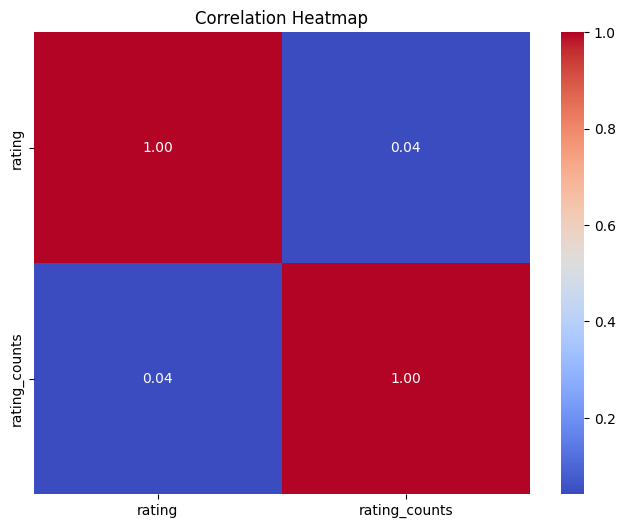

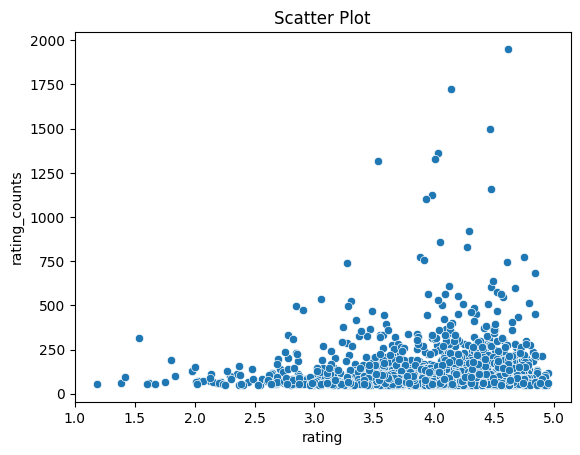

In [111]:
plt.figure(figsize=(8, 6))
sns.heatmap(ratings_mean_count.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Scatter plot for two numeric variables
sns.scatterplot(x='rating', y='rating_counts', data=ratings_mean_count)
plt.title('Scatter Plot')
plt.show()

7. Multivariate Analysis

In [112]:
# Correlation heatmap for numeric columns
plt.figure(figsize=(8, 6))
sns.heatmap(df_user.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Scatter plot for two numeric variables
sns.scatterplot(x='numeric_column_1', y='numeric_column_2', data=df)
plt.title('Scatter Plot')
plt.show()

# Box plot for a categorical and numeric column
sns.boxplot(x='categorical_column', y='numeric_column', data=df)
plt.title('Box Plot')
plt.xticks(rotation=45)
plt.show()


ValueError: could not convert string to float: 'Such a lovely scent but not overpowering.'

<Figure size 800x600 with 0 Axes>

8. Analyzing Product Reviews (if applicable)

In [113]:
# Check the length of reviews (replace 'review_column' with the actual name)
if 'text_review' in df_user.columns:
    df_user['review_length'] = df_user['text_review'].str.len()

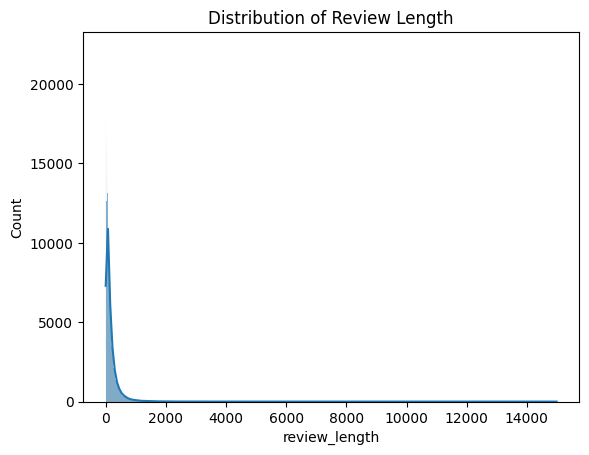

In [114]:
sns.histplot(df_user['review_length'], kde=True)
plt.title('Distribution of Review Length')
plt.show()

In [116]:
# Word Cloud of reviews (optional)
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['review_column'].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

NameError: name 'df' is not defined

9. Grouping and Aggregations

In [117]:
# Example: Average rating per product
if 'product_id' in df.columns and 'rating' in df.columns:
    avg_rating = df.groupby('product_id')['rating'].mean().sort_values(ascending=False)
    print(avg_rating.head())

# Example: Total sales by category
if 'category_column' in df.columns and 'sales_column' in df.columns:
    total_sales = df.groupby('category_column')['sales_column'].sum().sort_values(ascending=False)
    print(total_sales)


NameError: name 'df' is not defined

10. Save Cleaned Data (Optional)

In [118]:
# Save cleaned data to a new CSV file
df.to_csv('cleaned_ecommerce_data.csv', index=False)
print("Cleaned data saved successfully!")


NameError: name 'df' is not defined